# How many times has each K2 pixel been telemetered?

In this demo notebook we are going to identify which pixels were observed in long cadence (LC) during campaign 13.  Our final goal is to have a boolean mask the same dimensions as an FFI, with either 1 (was observed) or 0 (not observed).  Our approach will be simply to read in every single TPF and access the `APERTURE` keyword.  Values of `APERTURE` greater than zero are observed, while zero values were not.  We will also need to read the FITS header to determine the *x,y* coordinate of the corner of the TPF.  Finally we will programmatically fill in a count array with ones or zeros.

Make the Jupyter Notebook fill the screen.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.console import ProgressBar
import logging
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Open the Campaign 13 FFI to mimic the dimensions and metadata.

In [3]:
hdu_ffi = fits.open('/Volumes/Truro/ffi/ktwo2017079075530-c13_ffi-cal.fits')

Open the [k2 Target Index](https://github.com/barentsen/k2-target-index) csv file, which is only updated to Campaign 13 at the time of writing.

In [4]:
df = pd.read_csv('../../k2-target-index/k2-target-pixel-files.csv.gz')

For this notebook, we will look at *ALL Campaigns*.

In [5]:
hdu_ffi[10].name

'MOD.OUT 4.2'

In [6]:
df.groupby(['campaign','module', 'output']).filename.count().tail(10)

campaign  module  output
112       22      3          804
                  4          350
          23      1          121
                  2          139
                  3          220
                  4          648
          24      1          944
                  2          205
                  3          136
                  4         1194
Name: filename, dtype: int64

In [7]:
df['mod_str'] = "MOD.OUT "+df.module.astype(str)+'.'+df.output.astype(str)

In [8]:
df['mod_str'].tail()

425578    MOD.OUT 17.1
425579    MOD.OUT 16.4
425580    MOD.OUT 13.4
425581     MOD.OUT 8.4
425582    MOD.OUT 19.4
Name: mod_str, dtype: object

We'll make an **"FFI Counts" array**, which is an array the same dimensions as the FFI, but with values of whether a pixel was telemetered in Long Cadence or not.

For the next part, you'll need a local hard drive full of all the K2 target pixel files.  It's a single line `wget` script to [MAST](https://archive.stsci.edu/pub/k2/target_pixel_files/c13/).  It's possible that the downloading process would corrupt a few target pixel files, and you wouldn't necessarily know.  So we will also set up a log of the failed attempts to open a target pixel file.

In [9]:
! ls /Volumes/burlingame/TPFs/

c0   c101 c111 c12  c14  c3   c5   c7   c91
c1   c102 c112 c13  c2   c4   c6   c8   c92


In [10]:
df.campaign.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  91,  92, 101, 102,
       111, 112,  12,  13])

In [11]:
logging.basicConfig(filename='../data/all_failed_TPFs.log',level=logging.INFO)

In [12]:
mod_list = df.mod_str.unique()
mod_list

array(['MOD.OUT 24.1', 'MOD.OUT 19.1', 'MOD.OUT 17.3', 'MOD.OUT 2.3',
       'MOD.OUT 4.3', 'MOD.OUT 4.4', 'MOD.OUT 12.4', 'MOD.OUT 18.2',
       'MOD.OUT 13.2', 'MOD.OUT 14.1', 'MOD.OUT 6.1', 'MOD.OUT 6.2',
       'MOD.OUT 10.2', 'MOD.OUT 20.3', 'MOD.OUT 20.1', 'MOD.OUT 20.4',
       'MOD.OUT 16.2', 'MOD.OUT 18.1', 'MOD.OUT 16.1', 'MOD.OUT 12.1',
       'MOD.OUT 23.4', 'MOD.OUT 8.1', 'MOD.OUT 11.1', 'MOD.OUT 18.3',
       'MOD.OUT 10.3', 'MOD.OUT 10.4', 'MOD.OUT 10.1', 'MOD.OUT 24.4',
       'MOD.OUT 20.2', 'MOD.OUT 9.2', 'MOD.OUT 22.2', 'MOD.OUT 12.2',
       'MOD.OUT 12.3', 'MOD.OUT 13.1', 'MOD.OUT 8.4', 'MOD.OUT 15.3',
       'MOD.OUT 24.3', 'MOD.OUT 13.4', 'MOD.OUT 2.1', 'MOD.OUT 17.1',
       'MOD.OUT 18.4', 'MOD.OUT 16.3', 'MOD.OUT 16.4', 'MOD.OUT 23.3',
       'MOD.OUT 15.2', 'MOD.OUT 2.4', 'MOD.OUT 9.3', 'MOD.OUT 22.4',
       'MOD.OUT 19.3', 'MOD.OUT 23.1', 'MOD.OUT 14.4', 'MOD.OUT 15.4',
       'MOD.OUT 23.2', 'MOD.OUT 14.3', 'MOD.OUT 4.2', 'MOD.OUT 17.4',
       'MOD.OUT 2.

Now set up a big for-loop that:
1. Reads in a TPFs 
2. Aligns its corner in the FFI frame
3. Adds a boolean mask to the **FFI Counts** array
4. Optionally logs any problem TPFs for spot-checking later
5. Incrementally saves the FFI Counts array to a FITS file

In [13]:
! ls ../data/FFI_counts/

C0_FFI_mask.fits   C12_FFI_mask.fits  C4_FFI_mask.fits   C91_FFI_mask.fits
C101_FFI_mask.fits C13_FFI_mask.fits  C5_FFI_mask.fits   C92_FFI_mask.fits
C102_FFI_mask.fits C1_FFI_mask.fits   C6_FFI_mask.fits
C111_FFI_mask.fits C2_FFI_mask.fits   C7_FFI_mask.fits
C112_FFI_mask.fits C3_FFI_mask.fits   C8_FFI_mask.fits


In [14]:
for campaign, c_group in df.groupby('campaign'):
    print('----------C{:}-----------'.format(campaign))
    local_dir = '/Volumes/burlingame/TPFs/c'+str(campaign)+'/'
    hdu_counts = hdu_ffi
    for i, el in enumerate(hdu_ffi[1:]):
        hdu_counts[el.name].data = hdu_counts[el.name].data*0.0

    with ProgressBar(len(c_group.mod_str.unique()), ipython_widget=True) as bar:
        for mod_out, group in c_group.groupby('mod_str'):
            #print(mod_out, end='  ')
            bar.update()
            mod_out_tpfs = group.url.str[59:].values
            for i, tpf_path in enumerate(mod_out_tpfs):
                try:
                    pass
                    #hdu_tpf = fits.open(local_dir+tpf_path)
                    #hdr = hdu_tpf['TARGETTABLES'].header
                    #cx, cy = hdr['1CRV4P'], hdr['2CRV4P']
                    #sx, sy = hdu_tpf['APERTURE'].shape
                    #counts = hdu_tpf['APERTURE'].data > 0
                    #hdu_counts[mod_out].data[cy:cy+sy, cx:cx+sx]=counts.T # Double check this!
                except:
                    print(1)
                    #logging.info(tpf_path+" had a problem: cx:{}, sx:{}, cy:{}, sy:{}".format(cx, sx, cy, sy))
                #hdu_tpf.close()
            outfile = '../data/FFI_counts/C{}_FFI_mask.fits'.format(str(campaign))
        hdu_counts.writeto(outfile, overwrite=True)

----------C0-----------


A Jupyter Widget


----------C1-----------


A Jupyter Widget


----------C2-----------


A Jupyter Widget


----------C3-----------


A Jupyter Widget


----------C4-----------


A Jupyter Widget


----------C5-----------


A Jupyter Widget


----------C6-----------


A Jupyter Widget


----------C7-----------


A Jupyter Widget


----------C8-----------


A Jupyter Widget


----------C12-----------


A Jupyter Widget


----------C13-----------


A Jupyter Widget


----------C91-----------


A Jupyter Widget


----------C92-----------


A Jupyter Widget


----------C101-----------


A Jupyter Widget


----------C102-----------


A Jupyter Widget


----------C111-----------


A Jupyter Widget


----------C112-----------


A Jupyter Widget

Ok, it took 8 minutes for 3 channels, or about 160 seconds per channel.  There are about 72 channels per pointing, so:

In [ ]:
160.0*72/60.0

In [ ]:
192.0/60

Counting all the pixels will take about 3.2 hours.  That's a long time!  Meep!  
Let's have the for loop incrementally save each channel count so we can start working with the count data.

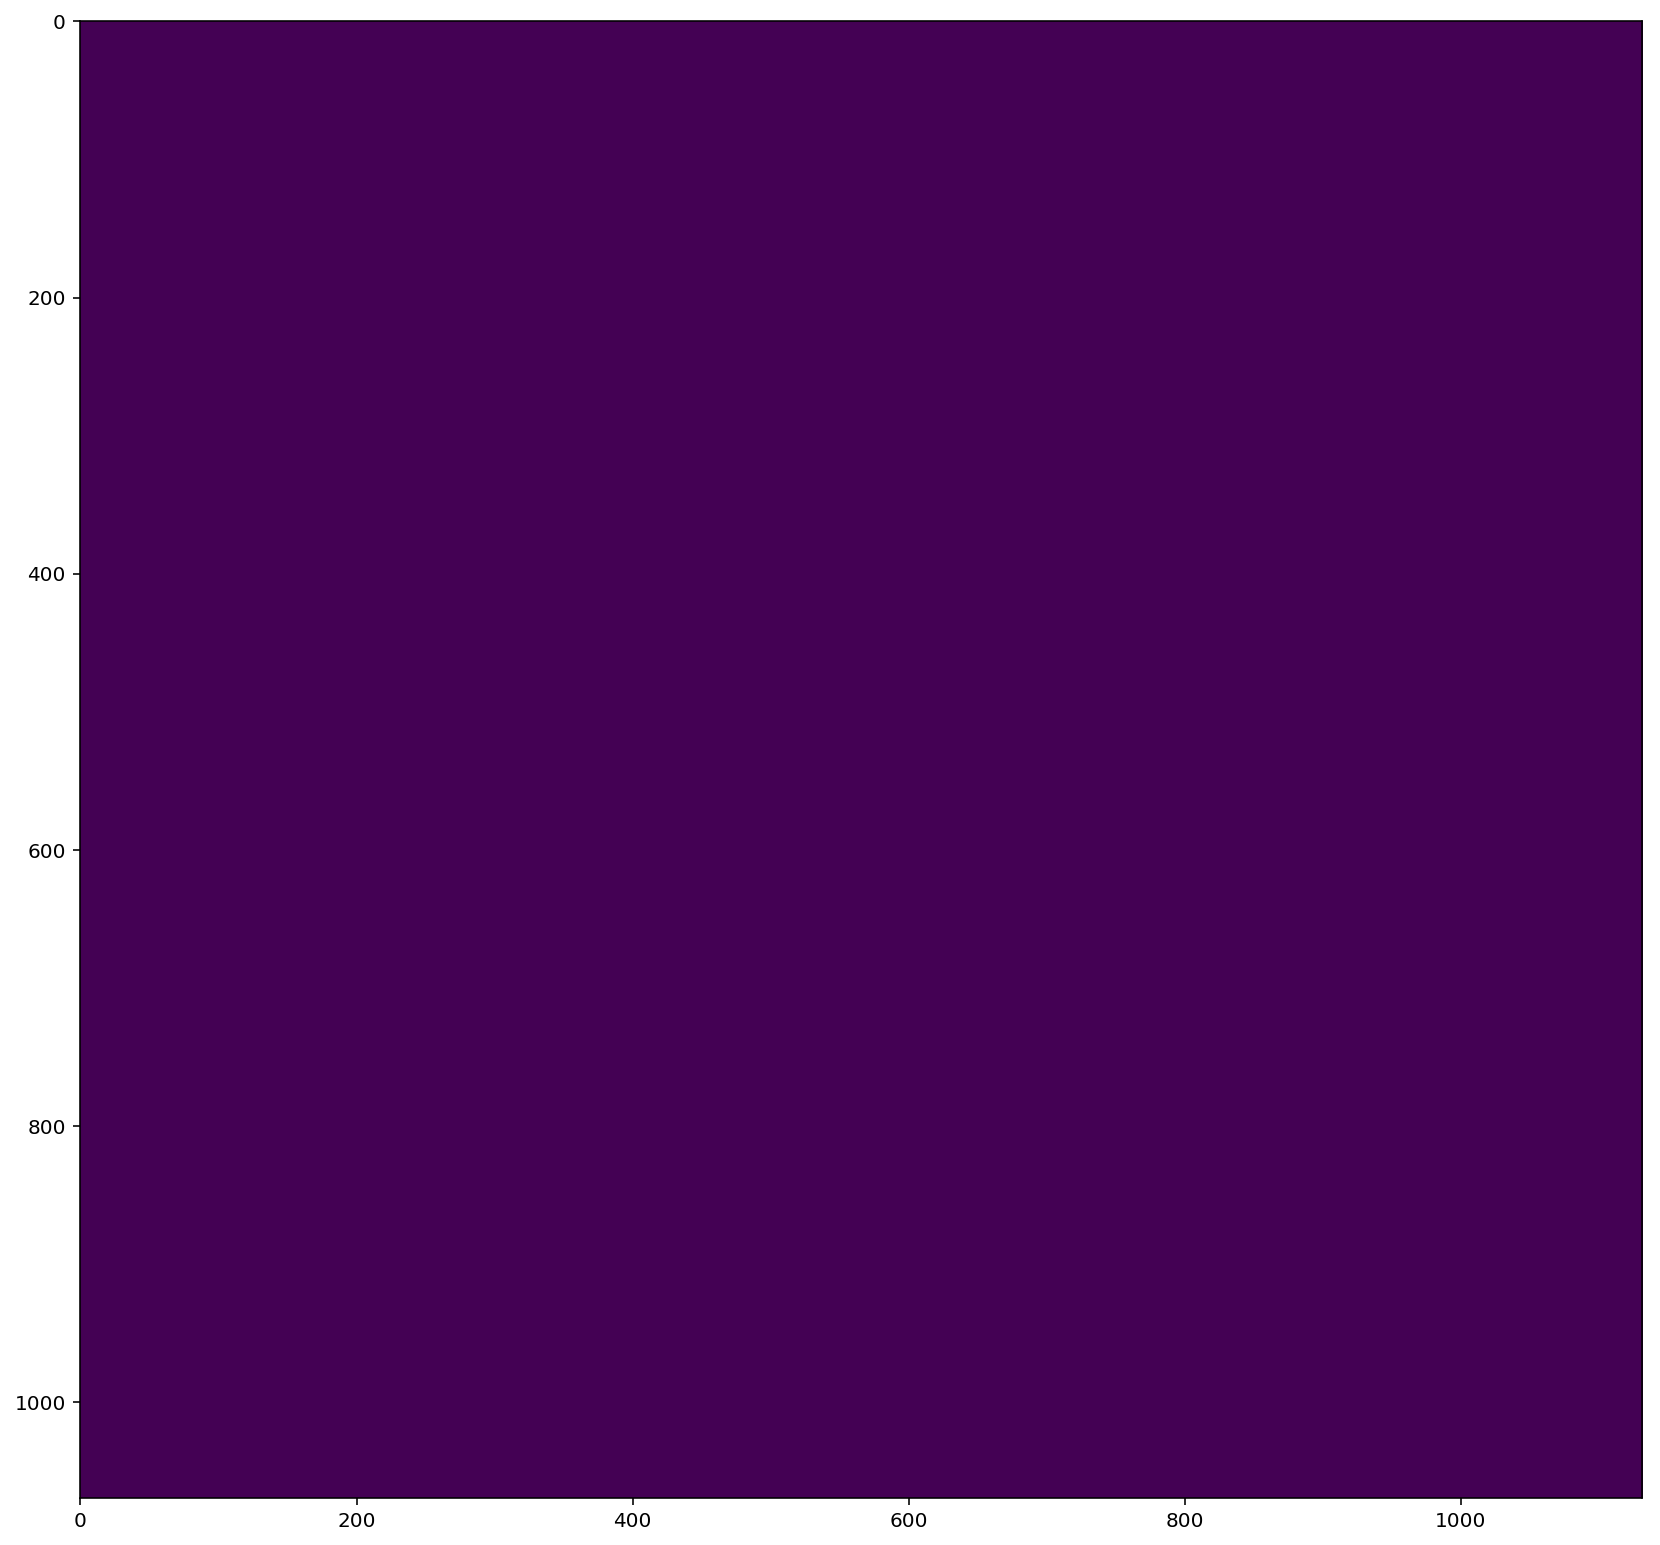

In [15]:
plt.figure(figsize=(14,14))
plt.imshow(hdu_counts['MOD.OUT 8.1'].data, interpolation='none', );

The end!